## Get data

In [2]:
import requests

# from https://github.com/poleval/2021-question-answering
url = "https://raw.githubusercontent.com/Ditectrev/Microsoft-Azure-AZ-900-Microsoft-Azure-Fundamentals-Practice-Tests-Exams-Questions-Answers/refs/heads/main/README.md"

response = requests.get(url)
response.raise_for_status()

if response.status_code == 200:
    lines = response.text.splitlines()
else:
    print("Nie udało się pobrać pliku.")

In [3]:
questions = []

for i, text in enumerate(lines[179 : (179 + 485)], 1):
    position1 = text.rfind('(')
    position2 = text.find('[')
    result = text[position2 + 1 : position1 - 1]
    questions.append(result)
    print(f"Question {i}: {result}")

questions[-5:]

Question 1: If you plan to host a web application in the Azure platform as a service solution of Azure Web Apps, then the platform will have the ability to scale automatically?
Question 2: You decide to create 2 Virtual machines. Each virtual machine is of the size D2s v3. Would these machines always generate the same monthly cost?
Question 3: Your team needs to have a tool that provides a digital online assistant that can provide speech support. Which of the following service can be used for this purpose?
Question 4: Your team needs to have a tool that can use past trainings to provide predictions of very high probability. Which of the following service can be used for this purpose?
Question 5: Your team needs to have a tool that can provide serverless computing capabilities. Which of the following service can be used for this purpose?
Question 6: Your team needs to have a tool that can be used to process data from millions of sensors. Which of the following service can be used for th

['Data that is copied to an Azure Storage account is maintained automatically in at least three copies.',
 'Your company has an on-premises network that contains multiple servers. The company plans to reduce the following administrative responsibilities of network administrators: Backing up application data. Replacing failed server hardware. Managing physical server security. Updating server operating systems. Managing permissions to shared documents. The company plans to migrate several servers to Azure virtual machines. You need to identify which administrative responsibilities will be eliminated after the planned migration. Which two responsibilities should you identify?',
 'Azure Cosmos DB is an example of a [Platform as a Service (PaaS)] offering.',
 '[Authorization] is the process of verifying a user credentials.',
 'You plan to migrate several servers from an on-premises network to Azure. You need to identify the primary benefit of using a public cloud service for the servers. W

## Generate embeddings

In [4]:
from sentence_transformers import SentenceTransformer
import numpy as np


# small multilingual model (larger are better)
model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.89k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [5]:
# Generuj embeddingi
embeddings = model.encode(questions)

print("Embeddings shape:", embeddings.shape)

Embeddings shape: (485, 384)


In [6]:
# embeddings range
embeddings.min(), embeddings.max()

(np.float32(-1.0594559), np.float32(1.0916411))

##Clustering with k-means

In [9]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Let assume 10 types of questions
num_clusters = 10

# KMeans
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(embeddings)

# Etkiety klastrów
labels = kmeans.labels_

# Pokaż, jak pytania zostały przypisane
questions_to_print = 5
for cluster_number in range(num_clusters):
  counter = 0
  for question, label in zip(questions, labels):
    if label == cluster_number:
      print(f"[Cluster {label}] {question}")
      counter += 1
      if counter == questions_to_print:
        print("...")
        break

[Cluster 0] A company is planning on hosting an application on an Azure Virtual Machine. It needs to be ensured that the application hosted on the virtual machine is accessible from the Internet over HTTPS. You decide to implement a DDoS protection plan. Would this satisfy the requirement?
[Cluster 0] A company is planning on hosting an application on an Azure Virtual Machine. It needs to be ensured that the application hosted on the virtual machine is accessible from the Internet over HTTPS. You decide to implement an Azure Traffic Manager profile. Would this satisfy the requirement?
[Cluster 0] Which of the following customers are eligible to use Azure Government to develop a cloud solution? Choose 2 answers from the options given below.
[Cluster 0] You need to create a virtual machine in Azure. Which of the following storage account service is used to store the data disks for the virtual machine?
[Cluster 0] Which of the following is a benefit of moving on-premises servers to the Az

##Visuallization

variance_explained = 17.53% - should be around 90%,
~12% is very low quality




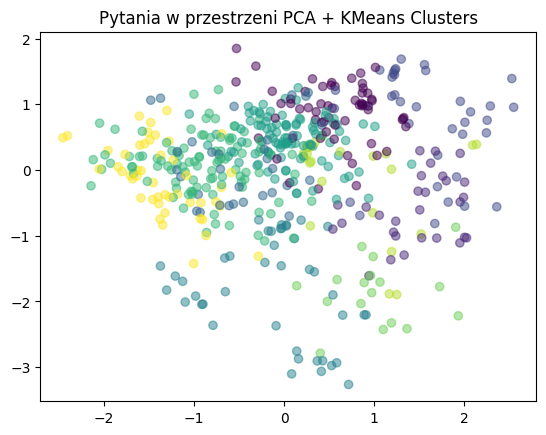

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

reduced_embeddings = pca.fit_transform(embeddings)

variance_explained = sum(pca.explained_variance_ratio_).item()
print(f"{variance_explained = :.2%} - should be around 90%,\n\
~12% is very low quality\n\n")

plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, alpha=0.5)
# for i, question in enumerate(questions):
#     plt.annotate(str(i), (reduced_embeddings[i, 0], reduced_embeddings[i, 1]))
plt.title("Pytania w przestrzeni PCA + KMeans Clusters")
plt.show()

## Another visualization with TSNE and DBSCAN (both standard tools)

In [11]:
from sklearn.manifold import TSNE

# clustering with TSNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

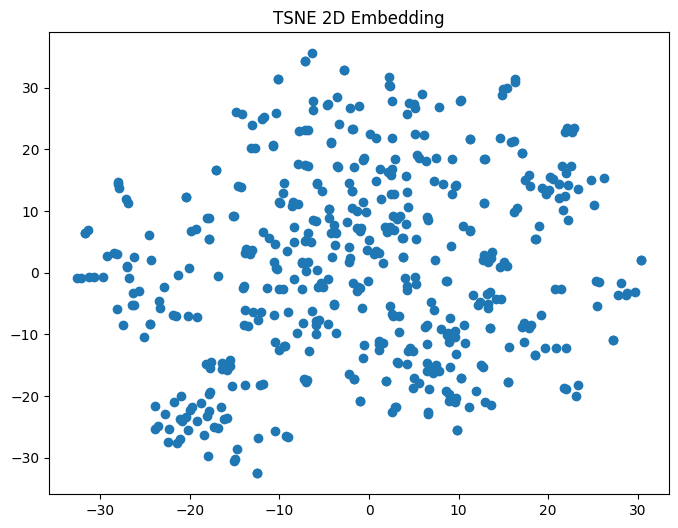

In [12]:
# print TSNE result
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
# for i, question in enumerate(questions):
#     plt.annotate(f"{i}: {question[:30]}...", (embeddings_2d[i, 0], embeddings_2d[i, 1]))
plt.title("TSNE 2D Embedding")
plt.show()

In [18]:
from sklearn.cluster import DBSCAN
from collections import Counter


dbscan = DBSCAN(eps=5, min_samples=1)  # Dostosuj eps
dbscan_labels = dbscan.fit_predict(embeddings_2d)

c = dict(Counter(dbscan_labels))

print(f"DBSCAN have found {len(c)} clusters:")
print(c)
print("\n\n clusters are highly imbalanced, use then k-means again but ot t-sne representation")

DBSCAN have found 5 clusters:
{np.int64(0): 470, np.int64(1): 2, np.int64(2): 4, np.int64(3): 5, np.int64(4): 4}


 clusters are highly imbalanced, use then k-means again but ot t-sne representation


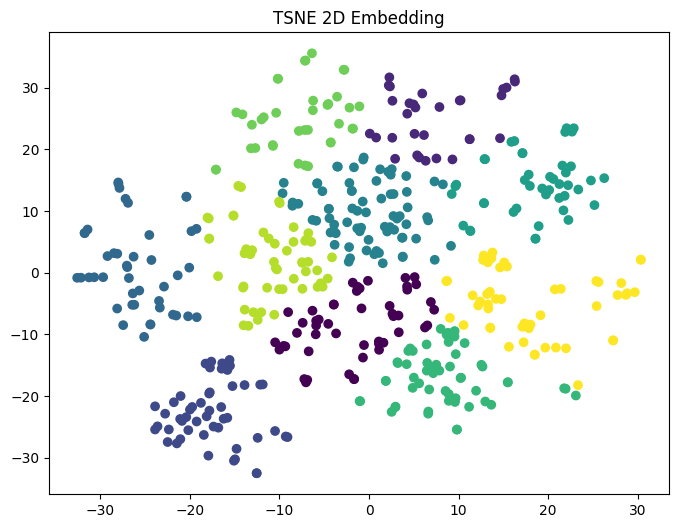

In [19]:
# kmeans again

kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(embeddings_2d)

# Etkiety klastrów
labels = kmeans.labels_

# print TSNE result
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels)
plt.title("TSNE 2D Embedding")
plt.show()

In [20]:
# Pokaż, jak pytania zostały przypisane
questions_to_print = 5
for cluster_number in range(num_clusters):
  counter = 0
  for question, label in zip(questions, labels):
    if label == cluster_number:
      print(f"[Cluster {label}] {question}")
      counter += 1
      if counter == questions_to_print:
        print("...")
        break

[Cluster 0] If you plan to host a web application in the Azure platform as a service solution of Azure Web Apps, then the platform will have the ability to scale automatically?
[Cluster 0] A company is planning on hosting an application on an Azure Virtual Machine. It needs to be ensured that the application hosted on the virtual machine is accessible from the Internet over HTTPS. You decide to implement a DDoS protection plan. Would this satisfy the requirement?
[Cluster 0] A company is planning on hosting an application on an Azure Virtual Machine. It needs to be ensured that the application hosted on the virtual machine is accessible from the Internet over HTTPS. You decide to implement an Azure Traffic Manager profile. Would this satisfy the requirement?
[Cluster 0] If you plan to host a web application in the Azure platform as a service solution of Azure Web Apps, then you will have complete control over the underlying operating system.
[Cluster 0] Under which of the following cir

##Similar questions

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity


similarities = cosine_similarity(embeddings, embeddings)
np.fill_diagonal(similarities, val=0)  # set self-similarity of question to zero
similarities[:5,:5]

array([[0.        , 0.10809155, 0.33942288, 0.3100394 , 0.22426268],
       [0.10809155, 0.        , 0.13779157, 0.24296   , 0.17021835],
       [0.33942288, 0.13779157, 0.        , 0.38711566, 0.4144085 ],
       [0.3100394 , 0.24296   , 0.38711566, 0.        , 0.26405236],
       [0.22426268, 0.17021835, 0.4144085 , 0.26405236, 0.        ]],
      dtype=float32)

In [ ]:
most_similar_idx = np.argmax(similarities, axis=1)
most_similar_question = np.array(questions)[most_similar_idx]
similarity_score = np.max(similarities, axis=1)

for i in range(10):
  print(f"Question: {questions[i]}")
  print(f"Most similar: {most_similar_question[i]}")
  print("\n")

# print(f"Najbardziej podobne pytanie: {most_similar_question}")
# print(f"Podobieństwo: {similarity_score:.3f}")

Question: W którym państwie została ogłoszona „Deklaracja praw człowieka i obywatela”?
Most similar: W którym mieście w USA podpisano Kartę Narodów Zjednoczonych?


Question: Która kawa zawiera alkohol: po turecku czy po irlandzku?
Most similar: Z jakiego państwa pochodzi szampan?


Question: W którym mieście zmarł Sławomir Mrożek?
Most similar: W którym mieście zginął Zbyszek Cybulski?


Question: Jak nazywał się autor powieści „Wierna rzeka”?
Most similar: Jak nazywał się autor powieści „Martwe Dusze”?


Question: W którym polskim mieście wybrzeża znajduje się Fontanna Neptuna?
Most similar: W którym warszawskim parku znajduje się Pałac na Wodzie?


Question: Na którym kontynencie leżała Kartagina?
Most similar: Na jakim kontynencie żyli Goci?


Question: Jak nazywał się reżyser pierwszego polskiego w filmu w 3D: „Bitwa Warszawska”?
Most similar: Jak nazywa się polski reżyser, mąż Jadwigi Barańskiej?


Question: Które owady australijskie tworzą ogromne kopce, wysokie na 6 metrów?
Mos

In [ ]:
j

np.str_('W którym mieście w USA podpisano Kartę Narodów Zjednoczonych?')